In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load
import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import  RandomizedSearchCV
from time import time
from scipy.stats import uniform
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
from scipy.stats import randint

# Load Input Data

In [2]:
# Load Inputs
# Load X and y values
X = load('X.joblib') 
y= load('y.joblib')


# Randomaly  Spit train test (20%) 

In [3]:
X_train,X_test,y_train,y_test= train_test_split(X ,y,test_size=0.20, random_state=0)

# Hyper Parameter tuning on train data 10fold CV and RandomizedSearchCV

In [4]:
svReg = SVR()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {'kernel': ['rbf'],
              'gamma': ['scale', 'auto'],
              'C': uniform(0, 100),
              'epsilon': loguniform(1e-4, 1e1),
             }

# run random search
n_iter_search = 100
random_search = RandomizedSearchCV(svReg, param_distributions=param_dist,scoring='r2',cv=10,n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)

print("randomSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(random_search.cv_results_['params'])))
report(random_search.cv_results_)

randomSearchCV took 282.99 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.544 (std: 0.055)
Parameters: {'C': 82.75547111328812, 'epsilon': 0.06250724657440772, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.542 (std: 0.058)
Parameters: {'C': 99.41694391846941, 'epsilon': 0.004999000984397914, 'gamma': 'scale', 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.542 (std: 0.058)
Parameters: {'C': 97.32521714862627, 'epsilon': 0.0012312751420951395, 'gamma': 'scale', 'kernel': 'rbf'}



# Fit model with selected hyperparameters on train data and test it on test data

Coefficient of determination of base SVR model on test data is , 0.5758917578867152


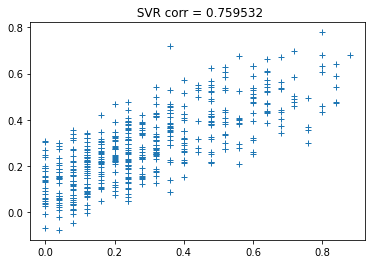

In [12]:
#regLin=SVR(C=30,gamma='scale',kernel='rbf',epsilon=0.01).fit(X_train, y_train)
regLin=SVR(C=30,gamma='scale',kernel='rbf',epsilon=0.01).fit(X_train, y_train)
#regLin=SVR(C=80,gamma='scale',kernel='rbf',epsilon=0.06).fit(X_train, y_train)
acc_svr       =regLin.score(X_test, y_test) 
print("Coefficient of determination of base SVR model on test data is ,",(acc_svr))
yy_test = regLin.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' SVR corr = %f'%test_corr)
plt.plot(y_test,yy_test,'+')

# Predict all data

In [6]:
yLR=regLin.predict(X)
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TSdataSVR.joblib')

['TSdataSVR.joblib']

# PLot TS 

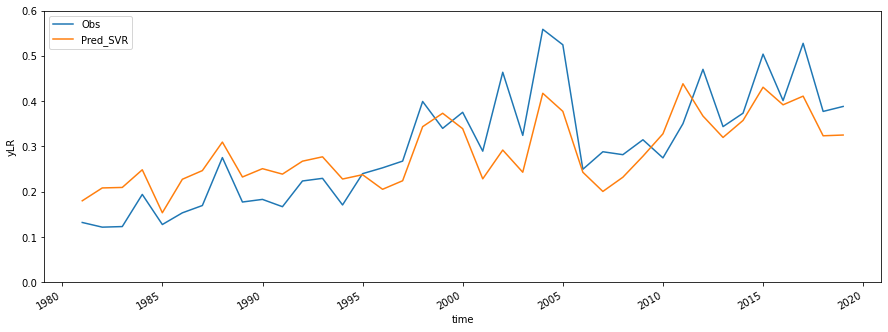

In [7]:

plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_SVR')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()


# Get Categorial Fog days

In [8]:
ynf=y.where(y<0.040, drop=True)
print(ynf.shape[0])

yint1=y.where(y>=0.04,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
print(yintf.shape[0])

yWd=y.where(y>=0.48, drop=True)
print(yWd.shape[0])

print((ynf.shape[0]+yintf.shape[0]+yWd.shape[0]))

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>=0.48,drop=True)
print(yLRWd.yLR.shape[0])

print((yLRnf.yLR.shape[0]+yLRintf.yLR.shape[0]+yLRWd.yLR.shape[0]))

125
1705
588
2418
90
2052
276
2418


# PLot pie chart of different Categories

Text(0.5, 1.0, 'SVR')

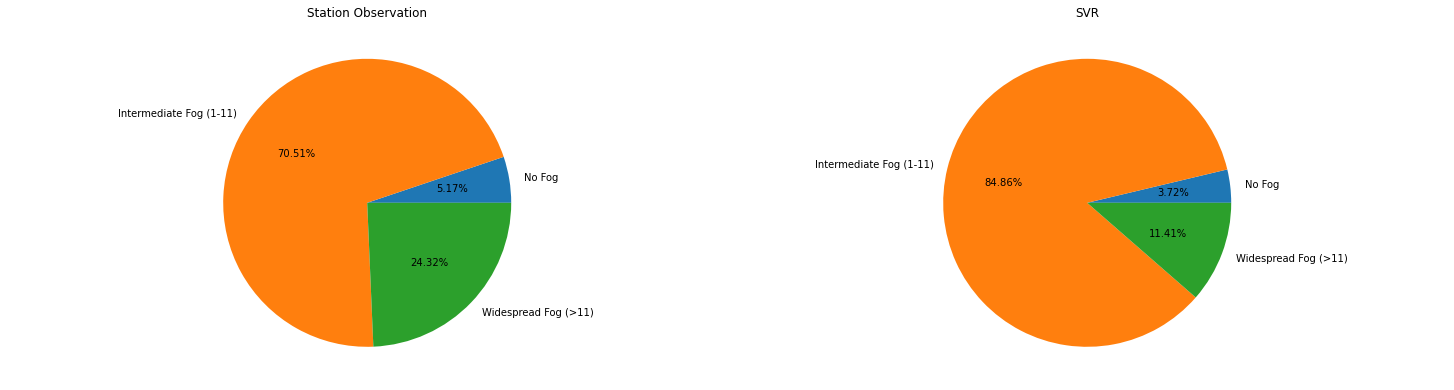

In [9]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('SVR')

In [10]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'piedataSVR.joblib')

['piedataSVR.joblib']